In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


### Custom classifier on custom pretrained model

In [2]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
X_test = list(df_test['text'])

In [6]:
X_train = list(df_train['text'])
y_train = np.array(df_train['target'])

In [7]:
from transformers import AutoTokenizer,TFAutoModel
tokenizer =AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
train_encoding = tokenizer(X_train,return_tensors="tf",truncation=True, padding=True)
max_length = train_encoding.input_ids.shape[1]
test_encoding = tokenizer(X_test,return_tensors="tf",truncation=True, padding='max_length',max_length=max_length)

In [9]:
print(train_encoding['input_ids'].shape)
print(test_encoding['input_ids'].shape)

(7613, 84)
(3263, 84)


In [10]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
model.bert.trainable=False
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


In [12]:
# This can change, it depend of the max size of the sentences
s = train_encoding['input_ids'].shape[1]

# The Bert inputs
input_ids = tf.keras.layers.Input(shape=(s,), name='input_ids', dtype='int32')
token_type_ids = tf.keras.layers.Input(shape=(s,), name='token_type_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(s,), name='attention_mask', dtype='int32')

# We use only the first output of the Bert model : last_hidden_state
# We don't use the others
embedding = model(input_ids,token_type_ids, attention_mask)
X = embedding[0][:,0,:] 

# And now come our custom classifier
X = tf.keras.layers.Dropout(0.2)(X)
for _ in range(4):
    X = tf.keras.layers.Dense(100, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)

# The output of our model 
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)

# We assemble the different parts
new_model = tf.keras.Model([input_ids,token_type_ids, attention_mask], outputs = X)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 84)]                 0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 84)]                 0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 84)]                 0         []                            
 )                                                                                                
                                                                                              

In [13]:
patience = 15
callbacks_list = [tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss',
                  min_delta=1e-10,
                  restore_best_weights=True,
                  patience=patience),
                  tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor =0.95,
            patience=3)]

In [14]:
from tensorflow.keras.optimizers import Adam

new_model.compile(optimizer=Adam(3e-5), loss = 'binary_crossentropy', metrics= ['accuracy'])

history = new_model.fit(
    x = dict(train_encoding), 
    y = y_train,
    callbacks = callbacks_list,
    epochs = 150,
    validation_split = 0.20)

Epoch 1/150
191/191 [==============================] - 51s 183ms/step - loss: 0.6775 - accuracy: 0.5793 - val_loss: 0.6516 - val_accuracy: 0.7144 - lr: 3.0000e-05
Epoch 2/150
191/191 [==============================] - 31s 164ms/step - loss: 0.6544 - accuracy: 0.6087 - val_loss: 0.6069 - val_accuracy: 0.7735 - lr: 3.0000e-05
Epoch 3/150
191/191 [==============================] - 31s 164ms/step - loss: 0.6358 - accuracy: 0.6488 - val_loss: 0.5527 - val_accuracy: 0.7866 - lr: 3.0000e-05
Epoch 4/150
191/191 [==============================] - 31s 164ms/step - loss: 0.6041 - accuracy: 0.6782 - val_loss: 0.5168 - val_accuracy: 0.7938 - lr: 3.0000e-05
Epoch 5/150
191/191 [==============================] - 31s 164ms/step - loss: 0.5847 - accuracy: 0.7016 - val_loss: 0.4910 - val_accuracy: 0.7984 - lr: 3.0000e-05
Epoch 6/150
191/191 [==============================] - 31s 163ms/step - loss: 0.5702 - accuracy: 0.7232 - val_loss: 0.4779 - val_accuracy: 0.7958 - lr: 3.0000e-05
Epoch 7/150
191/191 [=

Accuracy: 0.8148391246795654


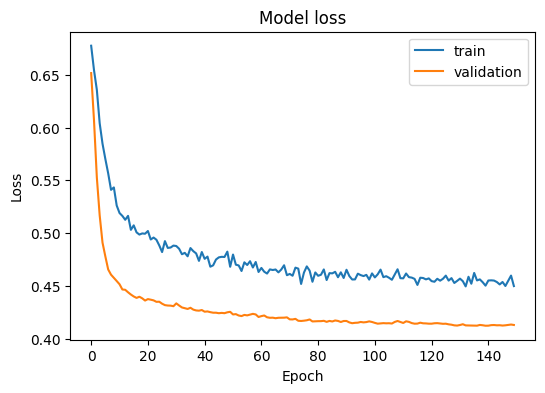

In [15]:
acc = max(history.history['val_accuracy'])
print(f'Accuracy: {acc}')
df_loss = pd.DataFrame(history.history)
df_loss= df_loss[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss');

In [16]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = new_model.predict(dict(test_encoding),verbose=False)
submission['target'] = (submission['target']  >0.5).astype(int)
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [17]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
